# Классификатор аудио сэмплов с сайта freeesound

Для этого проекта я написал парсер сайта freesound, код от него находится в файле parser.py

По результатам парсинга было в сумме получено 1005 сэмплов по 4 тегам: вода, синтезатор, барабаны, вокал

## Анализ данных

Для начала требуется проверить, какой тип аудиоданных был в итоге спрашен, и воспадают ли такие характеристики, как sample rate, длина аудиозаписей, количество каналов

In [1]:
import os
import soundfile as sf
import numpy as np

CLASSES = ['drum', 'synthesizer', 'voice', 'water']

def analyze_audio_metadata(root_dir="dataset"):
    stats = {}
    
    for class_name in CLASSES:
        folder_name = f"{class_name}_samples"
        folder_path = os.path.join(root_dir, folder_name)
        
        file_list = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.mp3')])
        
        meta_list = []
        for fname in file_list:
            file_path = os.path.join(folder_path, fname)
            try:
                
                info = sf.info(file_path)
                
                
                duration = info.frames / float(info.samplerate)
                
                
                meta = {
                    "filename": fname,
                    "samplerate": info.samplerate,
                    "channels": info.channels,
                    "frames": info.frames,
                    "duration_sec": duration,
                    "format": info.format, 
                    "subtype": info.subtype,
                }
                meta_list.append(meta)
            
            except Exception as e:
                print(f"Ошибка чтения файла {file_path}: {e}")
        
        stats[class_name] = meta_list
    
    return stats

def print_stats(stats):
    for class_name, meta_list in stats.items():
        if not meta_list:
            print(f"{class_name}: нет файлов в статистике.")
            continue
        durations = [m["duration_sec"] for m in meta_list]
        srs = [m["samplerate"] for m in meta_list]
        
        avg_duration = np.mean(durations)
        max_duration = np.max(durations)
        percentile_95 = np.percentile(durations, 90)
        
        avg_sr = np.mean(srs)
        
        print(f"\n=== {class_name} ===")
        print(f" Files: {len(meta_list)}")
        print(f" Average duration in seconds: {avg_duration:.2f}")
        print(f" Max duration in seconds: {max_duration:.2f}")
        print(f" 95th percentile in seconds: {percentile_95:.2f}")
        print(f" Average sample rate: {avg_sr:.1f}")

        channels_list = [m["channels"] for m in meta_list]
        print(f" Channels: {set(channels_list)}")

def main():
    stats = analyze_audio_metadata(root_dir="dataset")
    print_stats(stats)

if __name__ == "__main__":
    main()



=== drum ===
 Files: 254
 Average duration in seconds: 12.14
 Max duration in seconds: 30.00
 95th percentile in seconds: 24.43
 Average sample rate: 24000.0
 Channels: {2}

=== synthesizer ===
 Files: 249
 Average duration in seconds: 14.14
 Max duration in seconds: 30.00
 95th percentile in seconds: 25.02
 Average sample rate: 24000.0
 Channels: {2}

=== voice ===
 Files: 253
 Average duration in seconds: 9.05
 Max duration in seconds: 30.00
 95th percentile in seconds: 21.22
 Average sample rate: 24000.0
 Channels: {2}

=== water ===
 Files: 249
 Average duration in seconds: 12.61
 Max duration in seconds: 29.84
 95th percentile in seconds: 26.00
 Average sample rate: 24000.0
 Channels: {2}


Слава богу, классы сбалансированы, это несколько упрощает задачу и мне не придётся лишний раз работать со звешиванием классов
#### Визуализация данных

Теперь требуется проверить, разделимы ли эти классы, ведь по идее все эти звуки имеют свой уникальный характер, а значит и в цифрах это должно выражаться

In [2]:
import os
import numpy as np
import librosa

CLASSES = ['drum', 'synthesizer', 'voice', 'water']


def extract_features_flat(file_path, duration=25.0, n_mels=64):
    y, sr = librosa.load(file_path, sr=None, duration=duration)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max) 
    
    flat = mel_db.flatten()  
    return flat

def pad_or_trim_features(features, target_length):
    if len(features) > target_length:
        return features[:target_length]
    elif len(features) < target_length:
        return np.pad(features, (0, target_length - len(features)), mode='constant')
    return features

def load_dataset_flat(root_dir="dataset", target_length=None):
    """Приколюха чисто для снижения размерности через t-sne и тд, не применим как нормальный датасет для работы с torch"""
    X_flat = []
    y = []
    for label_idx, class_name in enumerate(CLASSES):
        folder_name = f"{class_name}_samples"
        folder_path = os.path.join(root_dir, folder_name)
        file_list = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.mp3')])

        for fname in file_list:
            file_path = os.path.join(folder_path, fname)
            vec = extract_features_flat(file_path)
            
            if target_length is None:
                target_length = len(vec)
            
            vec = pad_or_trim_features(vec, target_length)
            X_flat.append(vec)
            y.append(label_idx)
    X_flat = np.array(X_flat, dtype=np.float32)  
    y = np.array(y, dtype=np.int32)             
    return X_flat, y




In [3]:
X_flat, labels = load_dataset_flat(root_dir="dataset")


In [4]:
len(X_flat)

1005

#### PCA

Воспользуемся методом главных компонент, а на получившемся графике посмотрим, “кучкуются” ли отдельные классы. Если классы хорошо разделяются, это хороший знак. Если всё перемешано, значит, в таком плоском пространстве отличия между классами не столь явны (возможно, CNN-модель найдет более тонкую нелинейную грань).

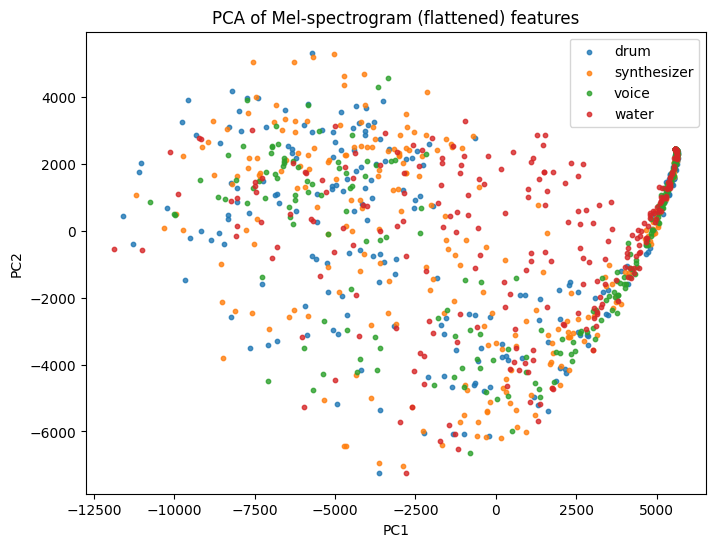

In [49]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)  # shape = (n_samples, 2)

plt.figure(figsize=(8,6))
for label_idx, class_name in enumerate(CLASSES):
    mask = (labels == label_idx)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, alpha=0.8, label=class_name)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Mel-spectrogram (flattened) features")
plt.legend()
plt.show()

В принципе, данные вполне себе кучкуются. Особенно Вода и Голос, они пошли в такой "хвост" справа, и видно, что там почти только объекты классов Вода и Голос.

#### t-SNE

Здесь также может отобразиться более наглядная кластеризация (иногда t-SNE “разрывает” данные на кластеры лучше, чем PCA). Но t-SNE более ресурсоёмок, чем PCA. 

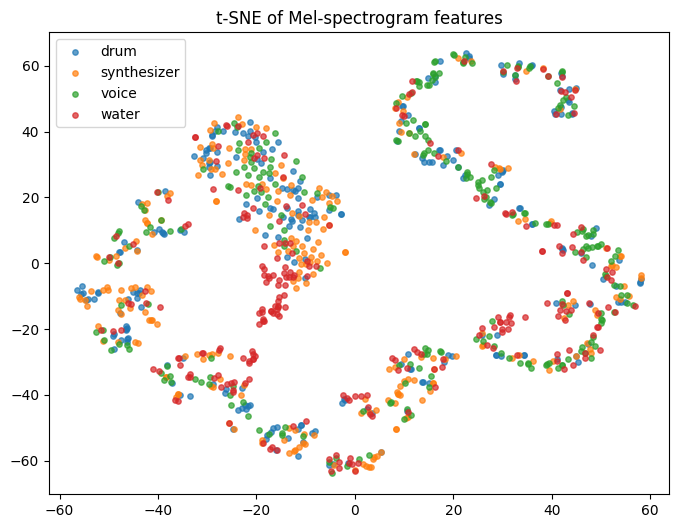

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_flat) 

plt.figure(figsize=(8,6))
for label_idx, class_name in enumerate(CLASSES):
    mask = (labels == label_idx)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=15, alpha=0.7, label=class_name)

plt.title("t-SNE of Mel-spectrogram features")
plt.legend()
plt.show()


Можно видеть, что также произошла довольно качественная кластеризация данных. Далеко не все, однако много объектов сгруппировались по своим группам по однородным цветам. Лучше всего отделились также вода и голос. 

Здесь я просто экспериментировал и смотрел на мел-спектрограммы, сравнивая с издаваемым звуком, чтобы лучше понять этот формат представления данных:

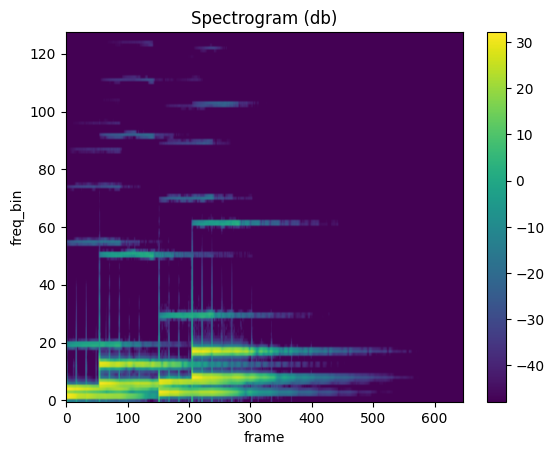

In [7]:

y, sr = librosa.load("dataset/synthesizer_samples/54bpm Lazy Summer Loop A1wav.mp3", duration=15)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)



fig, axs = plt.subplots(1, 1)
axs.set_title("Spectrogram (db)")
axs.set_ylabel("freq_bin")
axs.set_xlabel("frame")
im = axs.imshow(librosa.power_to_db(mel_spec), origin="lower", aspect="auto")

fig.colorbar(im, ax=axs)
plt.show(block=False)

In [8]:
y.shape

(330750,)

In [9]:
mel_spec.shape

(128, 646)

In [10]:
mel_db.shape

(128, 646)

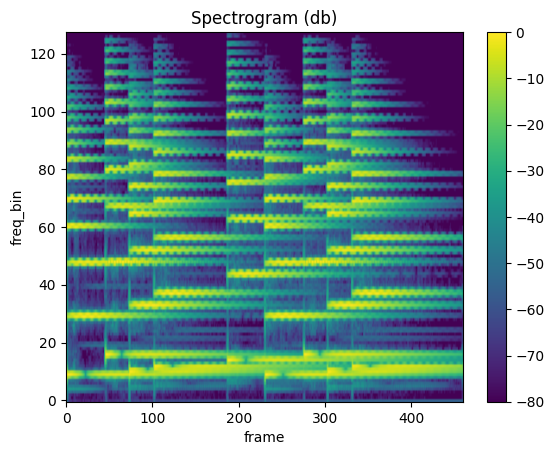

In [11]:
y, sr = librosa.load("dataset/synthesizer_samples/90_F_HeavensBellsDX7Synth_01.mp3", duration=25)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,n_fft=2048)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)



fig, axs = plt.subplots(1, 1)
axs.set_title("Spectrogram (db)")
axs.set_ylabel("freq_bin")
axs.set_xlabel("frame")
im = axs.imshow(mel_db, origin="lower", aspect="auto")

fig.colorbar(im, ax=axs)
plt.show(block=False)

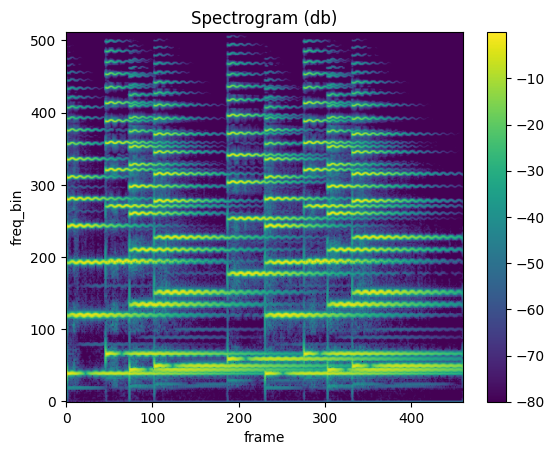

In [12]:
y, sr = librosa.load("dataset/synthesizer_samples/90_F_HeavensBellsDX7Synth_01.mp3", duration=25)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=512, n_fft=2048)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)



fig, axs = plt.subplots(1, 1)
axs.set_title("Spectrogram (db)")
axs.set_ylabel("freq_bin")
axs.set_xlabel("frame")
im = axs.imshow(mel_db, origin="lower", aspect="auto")

fig.colorbar(im, ax=axs)
plt.show(block=False)

In [13]:
mel_db.shape

(512, 460)

In [14]:
X_flat.shape

(1005, 57664)

In [15]:
y.shape

(235200,)

## Baseline

Построю бейзлайн на классическом алгоритме Random Forest, чтобы понимать, ниже какого уровня мы не имеем права опускаться. На вход подаются просто сплющенные мел-спектрограммы. 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, labels, test_size=0.2, random_state=42, shuffle=True
)

clf = RandomForestClassifier(
    n_estimators=1000,      
    max_depth=None,       
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test accuracy = {acc:.4f}")
print(f"Test F1 score = {f1:.4f}")


Test accuracy = 0.5124
Test F1 score = 0.5051


## CNN 

Построю нейросеть на свёртках, которая фактически могла бы принимать на вход спектрограмму как 2d картинку. 

### Dataset

In [19]:
import os
import glob
import torch
import librosa
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class AudioSampleDataset(Dataset):
    def __init__(self, root_dir, sample_rate=24000, n_mels=128, n_fft=2048, hop_length=512, max_frames=640):
        super().__init__()
        
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_frames = max_frames
        
        self.classes = {
            "drum_samples":0,
            "synthesizer_samples":1,
            "voice_samples":2,
            "water_samples":3
        }
        
        self.filepaths = []
        
        for folder_name, class_idx in self.classes.items():
            folder_path = os.path.join(self.root_dir, folder_name)
            
            paths = glob.glob(os.path.join(folder_path, "*.mp3"))
            for p in paths:
                self.filepaths.append((p, class_idx))
                
    def __len__(self):
        return len(self.filepaths)
    
    
    def __getitem__(self, index):
        
        audio_path, label = self.filepaths[index]
        
        y, sr = librosa.load(audio_path, sr=self.sample_rate, mono=False)
        
        if len(y.shape) == 2:
            y = np.mean(y, axis=0) # огрубление и просто приведение стерео к моно через усреднение значений на каналах
            
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr = self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels = self.n_mels
        )
        
        
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        #mel_spec_db_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-9)

        mel_tensor = torch.tensor(mel_spec_db, dtype=torch.float32)
        
        time_dim = mel_tensor.shape[1] # по идее (n_mels, time)

        if time_dim > self.max_frames:
            
            start = np.random.randint(0, time_dim - self.max_frames)
            mel_tensor = mel_tensor[:, start:start+self.max_frames]
            
        elif time_dim < self.max_frames:
            pad_width = self.max_frames - time_dim 
            mel_tensor = torch.cat([mel_tensor, torch.zeros(self.n_mels, pad_width)], dim=1)
            
        mel_tensor = mel_tensor.unsqueeze(0)
        
        
        return mel_tensor, label
    
    
    
    
        

### Сама модель

In [20]:
class SampleClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(SampleClassifier, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

### Цикл обучения

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score


def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=10,
    lr=1e-3,
    log_dir="runs/experiment"
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir=log_dir)

    model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_preds = []
        train_labels_all = []

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for batch_idx, (inputs, labels) in enumerate(train_loader_tqdm):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            train_preds.append(predicted.cpu().numpy())
            train_labels_all.append(labels.cpu().numpy())

        train_loss = running_loss / total
        train_acc = correct / total
        
        train_preds = np.concatenate(train_preds)
        train_labels_all = np.concatenate(train_labels_all)
        train_f1 = f1_score(train_labels_all, train_preds, average='weighted')

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_preds = []
        val_labels_all = []

        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_preds.append(predicted.cpu().numpy())
                val_labels_all.append(labels.cpu().numpy())

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        val_preds = np.concatenate(val_preds)
        val_labels_all = np.concatenate(val_labels_all)
        val_f1 = f1_score(val_labels_all, val_preds, average='weighted')

        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Val', val_loss, epoch)
        writer.add_scalar('Acc/Train', train_acc, epoch)
        writer.add_scalar('Acc/Val', val_acc, epoch)
        writer.add_scalar('F1/Train', train_f1, epoch)
        writer.add_scalar('F1/Val', val_f1, epoch)

    writer.close()


### Инициализация датасета и даталоадеров

In [28]:
root_dir = "dataset"
batch_size = 16


dataset_full = AudioSampleDataset(root_dir=root_dir)

train_size = int(len(dataset_full) * 0.8)
val_size = len(dataset_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Запуск обучения

In [29]:
root_dir = "dataset"  



model = SampleClassifier(num_classes=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


train_model(model, train_loader, val_loader, device, epochs=50, lr=3e-4)

torch.save(model.state_dict(), "audio_classifier_cnn.pth")

Using device: cuda


Epoch 1/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.61it/s]


Epoch [1/50] Train Loss: 1.3501, Train Acc: 0.3408, Train F1: 0.3430 | Val Loss: 1.3116, Val Acc: 0.3980, Val F1: 0.3849


Epoch 2/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.57it/s]


Epoch [2/50] Train Loss: 1.2757, Train Acc: 0.4080, Train F1: 0.3993 | Val Loss: 1.2332, Val Acc: 0.4925, Val F1: 0.4837


Epoch 3/50 [Train]: 100%|██████████| 51/51 [00:21<00:00,  2.43it/s]


Epoch [3/50] Train Loss: 1.2261, Train Acc: 0.4440, Train F1: 0.4374 | Val Loss: 1.1899, Val Acc: 0.4925, Val F1: 0.4949


Epoch 4/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


Epoch [4/50] Train Loss: 1.1542, Train Acc: 0.4925, Train F1: 0.4920 | Val Loss: 1.1545, Val Acc: 0.4726, Val F1: 0.4686


Epoch 5/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.44it/s]


Epoch [5/50] Train Loss: 1.1353, Train Acc: 0.5000, Train F1: 0.4988 | Val Loss: 1.0982, Val Acc: 0.5373, Val F1: 0.5372


Epoch 6/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.55it/s]


Epoch [6/50] Train Loss: 1.1122, Train Acc: 0.5075, Train F1: 0.5084 | Val Loss: 1.0998, Val Acc: 0.5124, Val F1: 0.5017


Epoch 7/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.56it/s]


Epoch [7/50] Train Loss: 1.0793, Train Acc: 0.5299, Train F1: 0.5291 | Val Loss: 1.1065, Val Acc: 0.5025, Val F1: 0.4952


Epoch 8/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.54it/s]


Epoch [8/50] Train Loss: 1.0713, Train Acc: 0.5336, Train F1: 0.5316 | Val Loss: 1.0626, Val Acc: 0.5423, Val F1: 0.5299


Epoch 9/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.55it/s]


Epoch [9/50] Train Loss: 1.0623, Train Acc: 0.5323, Train F1: 0.5308 | Val Loss: 1.0464, Val Acc: 0.5323, Val F1: 0.5210


Epoch 10/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


Epoch [10/50] Train Loss: 1.0395, Train Acc: 0.5498, Train F1: 0.5479 | Val Loss: 1.0431, Val Acc: 0.5473, Val F1: 0.5460


Epoch 11/50 [Train]: 100%|██████████| 51/51 [00:21<00:00,  2.40it/s]


Epoch [11/50] Train Loss: 1.0108, Train Acc: 0.5796, Train F1: 0.5791 | Val Loss: 1.0363, Val Acc: 0.5871, Val F1: 0.5723


Epoch 12/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Epoch [12/50] Train Loss: 1.0181, Train Acc: 0.5746, Train F1: 0.5756 | Val Loss: 1.0362, Val Acc: 0.5721, Val F1: 0.5477


Epoch 13/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.44it/s]


Epoch [13/50] Train Loss: 0.9907, Train Acc: 0.5622, Train F1: 0.5613 | Val Loss: 1.0048, Val Acc: 0.6070, Val F1: 0.6091


Epoch 14/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.64it/s]


Epoch [14/50] Train Loss: 0.9758, Train Acc: 0.5920, Train F1: 0.5922 | Val Loss: 1.0247, Val Acc: 0.5920, Val F1: 0.5795


Epoch 15/50 [Train]: 100%|██████████| 51/51 [00:21<00:00,  2.38it/s]


Epoch [15/50] Train Loss: 1.0085, Train Acc: 0.5672, Train F1: 0.5652 | Val Loss: 0.9964, Val Acc: 0.5672, Val F1: 0.5550


Epoch 16/50 [Train]: 100%|██████████| 51/51 [00:22<00:00,  2.31it/s]


Epoch [16/50] Train Loss: 0.9687, Train Acc: 0.6032, Train F1: 0.6022 | Val Loss: 1.0066, Val Acc: 0.5672, Val F1: 0.5706


Epoch 17/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.47it/s]


Epoch [17/50] Train Loss: 0.9597, Train Acc: 0.6095, Train F1: 0.6086 | Val Loss: 0.9791, Val Acc: 0.5920, Val F1: 0.5909


Epoch 18/50 [Train]: 100%|██████████| 51/51 [00:22<00:00,  2.30it/s]


Epoch [18/50] Train Loss: 0.9370, Train Acc: 0.6294, Train F1: 0.6287 | Val Loss: 0.9784, Val Acc: 0.6070, Val F1: 0.5980


Epoch 19/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


Epoch [19/50] Train Loss: 0.9297, Train Acc: 0.6182, Train F1: 0.6175 | Val Loss: 0.9485, Val Acc: 0.6219, Val F1: 0.6231


Epoch 20/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.63it/s]


Epoch [20/50] Train Loss: 0.9601, Train Acc: 0.5945, Train F1: 0.5943 | Val Loss: 0.9693, Val Acc: 0.6119, Val F1: 0.5952


Epoch 21/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.60it/s]


Epoch [21/50] Train Loss: 0.9121, Train Acc: 0.6169, Train F1: 0.6170 | Val Loss: 0.9712, Val Acc: 0.5721, Val F1: 0.5717


Epoch 22/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.66it/s]


Epoch [22/50] Train Loss: 0.9222, Train Acc: 0.6157, Train F1: 0.6156 | Val Loss: 1.3015, Val Acc: 0.4677, Val F1: 0.3921


Epoch 23/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


Epoch [23/50] Train Loss: 0.9094, Train Acc: 0.6393, Train F1: 0.6389 | Val Loss: 0.9246, Val Acc: 0.6368, Val F1: 0.6322


Epoch 24/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.58it/s]


Epoch [24/50] Train Loss: 0.8980, Train Acc: 0.6306, Train F1: 0.6312 | Val Loss: 0.9371, Val Acc: 0.6517, Val F1: 0.6437


Epoch 25/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.58it/s]


Epoch [25/50] Train Loss: 0.9107, Train Acc: 0.6269, Train F1: 0.6254 | Val Loss: 1.0886, Val Acc: 0.4975, Val F1: 0.4540


Epoch 26/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s]


Epoch [26/50] Train Loss: 0.8954, Train Acc: 0.6517, Train F1: 0.6521 | Val Loss: 1.0203, Val Acc: 0.5373, Val F1: 0.5194


Epoch 27/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Epoch [27/50] Train Loss: 0.8899, Train Acc: 0.6343, Train F1: 0.6337 | Val Loss: 1.0187, Val Acc: 0.5672, Val F1: 0.5514


Epoch 28/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


Epoch [28/50] Train Loss: 0.8935, Train Acc: 0.6318, Train F1: 0.6292 | Val Loss: 0.9065, Val Acc: 0.6517, Val F1: 0.6482


Epoch 29/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Epoch [29/50] Train Loss: 0.8784, Train Acc: 0.6468, Train F1: 0.6467 | Val Loss: 0.9175, Val Acc: 0.6269, Val F1: 0.6214


Epoch 30/50 [Train]: 100%|██████████| 51/51 [00:22<00:00,  2.24it/s]


Epoch [30/50] Train Loss: 0.8810, Train Acc: 0.6455, Train F1: 0.6459 | Val Loss: 1.1080, Val Acc: 0.5473, Val F1: 0.5463


Epoch 31/50 [Train]: 100%|██████████| 51/51 [00:21<00:00,  2.41it/s]


Epoch [31/50] Train Loss: 0.8635, Train Acc: 0.6592, Train F1: 0.6598 | Val Loss: 1.0081, Val Acc: 0.5920, Val F1: 0.5944


Epoch 32/50 [Train]: 100%|██████████| 51/51 [00:21<00:00,  2.38it/s]


Epoch [32/50] Train Loss: 0.8677, Train Acc: 0.6443, Train F1: 0.6441 | Val Loss: 0.9492, Val Acc: 0.6219, Val F1: 0.6279


Epoch 33/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Epoch [33/50] Train Loss: 0.8649, Train Acc: 0.6505, Train F1: 0.6496 | Val Loss: 1.0242, Val Acc: 0.5473, Val F1: 0.5005


Epoch 34/50 [Train]: 100%|██████████| 51/51 [00:22<00:00,  2.24it/s]


Epoch [34/50] Train Loss: 0.8509, Train Acc: 0.6617, Train F1: 0.6611 | Val Loss: 0.9126, Val Acc: 0.6617, Val F1: 0.6613


Epoch 35/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.54it/s]


Epoch [35/50] Train Loss: 0.8498, Train Acc: 0.6542, Train F1: 0.6539 | Val Loss: 0.8807, Val Acc: 0.6567, Val F1: 0.6562


Epoch 36/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Epoch [36/50] Train Loss: 0.8315, Train Acc: 0.6816, Train F1: 0.6818 | Val Loss: 0.9643, Val Acc: 0.5871, Val F1: 0.5659


Epoch 37/50 [Train]: 100%|██████████| 51/51 [00:21<00:00,  2.42it/s]


Epoch [37/50] Train Loss: 0.8312, Train Acc: 0.6754, Train F1: 0.6752 | Val Loss: 0.9368, Val Acc: 0.5970, Val F1: 0.5875


Epoch 38/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s]


Epoch [38/50] Train Loss: 0.8368, Train Acc: 0.6692, Train F1: 0.6695 | Val Loss: 1.0714, Val Acc: 0.5522, Val F1: 0.5296


Epoch 39/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.59it/s]


Epoch [39/50] Train Loss: 0.8157, Train Acc: 0.6766, Train F1: 0.6772 | Val Loss: 0.9034, Val Acc: 0.6318, Val F1: 0.6374


Epoch 40/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


Epoch [40/50] Train Loss: 0.8053, Train Acc: 0.6841, Train F1: 0.6843 | Val Loss: 0.8502, Val Acc: 0.6816, Val F1: 0.6805


Epoch 41/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.46it/s]


Epoch [41/50] Train Loss: 0.8221, Train Acc: 0.6878, Train F1: 0.6868 | Val Loss: 0.8497, Val Acc: 0.6468, Val F1: 0.6469


Epoch 42/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


Epoch [42/50] Train Loss: 0.8035, Train Acc: 0.6828, Train F1: 0.6828 | Val Loss: 0.8623, Val Acc: 0.6617, Val F1: 0.6569


Epoch 43/50 [Train]: 100%|██████████| 51/51 [00:20<00:00,  2.53it/s]


Epoch [43/50] Train Loss: 0.8021, Train Acc: 0.6642, Train F1: 0.6651 | Val Loss: 0.8439, Val Acc: 0.6866, Val F1: 0.6881


Epoch 44/50 [Train]: 100%|██████████| 51/51 [00:18<00:00,  2.69it/s]


Epoch [44/50] Train Loss: 0.7989, Train Acc: 0.6754, Train F1: 0.6750 | Val Loss: 1.2700, Val Acc: 0.5075, Val F1: 0.4475


Epoch 45/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


Epoch [45/50] Train Loss: 0.8042, Train Acc: 0.6816, Train F1: 0.6815 | Val Loss: 0.8346, Val Acc: 0.6716, Val F1: 0.6724


Epoch 46/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


Epoch [46/50] Train Loss: 0.7866, Train Acc: 0.7027, Train F1: 0.7035 | Val Loss: 0.8420, Val Acc: 0.6617, Val F1: 0.6662


Epoch 47/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.62it/s]


Epoch [47/50] Train Loss: 0.7725, Train Acc: 0.7065, Train F1: 0.7068 | Val Loss: 0.8543, Val Acc: 0.6418, Val F1: 0.6383


Epoch 48/50 [Train]: 100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


Epoch [48/50] Train Loss: 0.7815, Train Acc: 0.6953, Train F1: 0.6951 | Val Loss: 0.8260, Val Acc: 0.6866, Val F1: 0.6869


Epoch 49/50 [Train]: 100%|██████████| 51/51 [00:18<00:00,  2.70it/s]


Epoch [49/50] Train Loss: 0.7837, Train Acc: 0.6903, Train F1: 0.6905 | Val Loss: 0.9814, Val Acc: 0.5970, Val F1: 0.5774


Epoch 50/50 [Train]: 100%|██████████| 51/51 [00:18<00:00,  2.76it/s]
                                                                  

Epoch [50/50] Train Loss: 0.7760, Train Acc: 0.6928, Train F1: 0.6929 | Val Loss: 0.8383, Val Acc: 0.6667, Val F1: 0.6665


### Метрики

In [31]:
%load_ext tensorboard
%tensorboard --logdir=runs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16036), started 0:04:52 ago. (Use '!kill 16036' to kill it.)

Вот скриншоты из тензоборда, на которых видно. что модель успешно обучается, и что метрики на валидационных данных повышаются.

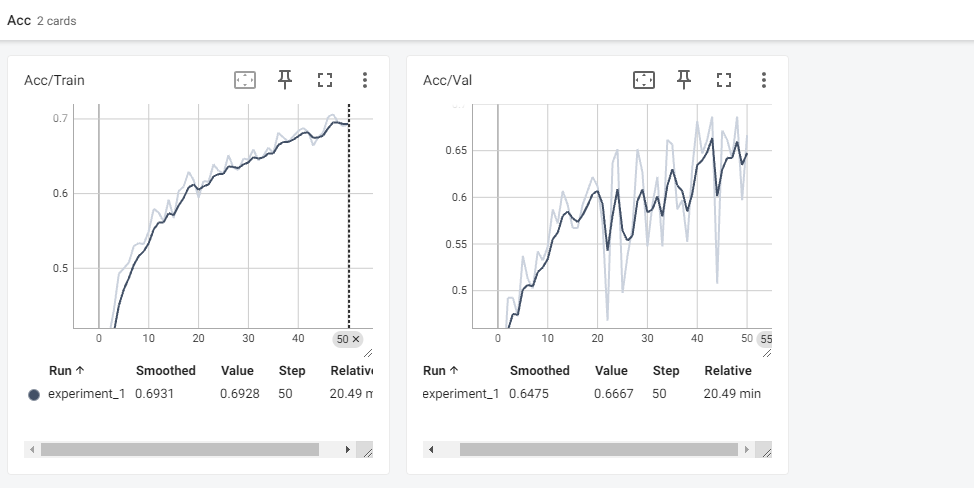

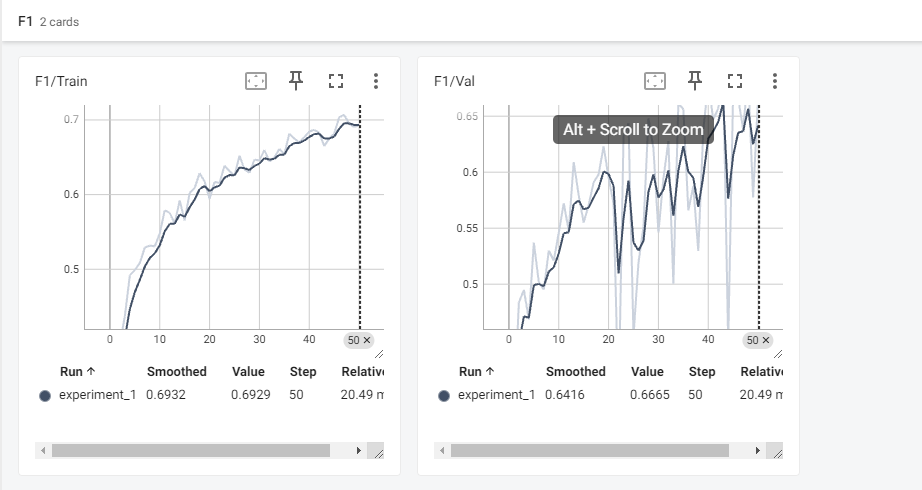

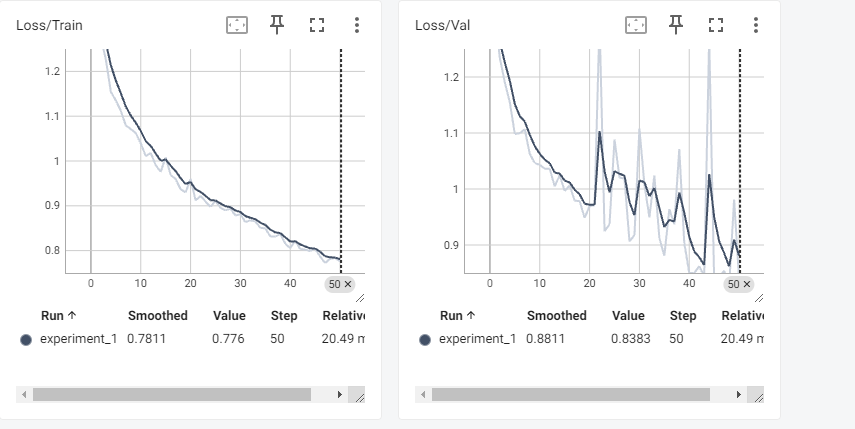

Модель показала себя лучше, чем бейзлайн. По графикам также видно, что переобучения не наблюдается, а лучшие метрики на валидационных данных были получены на 43-й эпохе:
Точность: 0.6866; 
Метрика F1: 0.6881

## Wave2Vec

Так как мы имеем не самое большое количество примеров, я решил попробовать использовать технологию transfer learning. Мы возьмём модель, которая уже достаточно хорошо распознаёт аудиоволны, и просто сверху сделаем часть с классификатором. Потенциально, такое решение может дать лучшие метрики.

### Dataset

In [32]:
import os
import glob
import torch
import librosa
from torch.utils.data import Dataset

class AudioDatasetRaw(Dataset):
    def __init__(
        self,
        root_dir,
        sample_rate=16000,
        max_duration_seconds=5.0
    ):

        super().__init__()
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.max_duration_seconds = max_duration_seconds

        self.classes = {
            'drum_samples': 0,
            'synthesizer_samples': 1,
            'voice_samples': 2,
            'water_samples': 3
        }

        self.filepaths = []
        for folder_name, class_idx in self.classes.items():
            folder_path = os.path.join(self.root_dir, folder_name)
            paths = glob.glob(os.path.join(folder_path, '*.mp3'))
            for p in paths:
                self.filepaths.append((p, class_idx))

        self.max_samples = int(self.sample_rate * self.max_duration_seconds)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        audio_path, label = self.filepaths[idx]
        
        y, sr = librosa.load(audio_path, sr=self.sample_rate, mono=True)

        if len(y) < self.max_samples:
            pad_length = self.max_samples - len(y)
            y = np.concatenate([y, np.zeros(pad_length, dtype=y.dtype)]) # паддинг
        else:
            y = y[:self.max_samples]


        audio_tensor = torch.tensor(y, dtype=torch.float32)
        
        return audio_tensor, label


### Сама модель

In [33]:
import torch.nn as nn
from transformers import Wav2Vec2Model

class Wave2Vec2Classifier(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base", num_classes=4, freeze_backbone=False):

        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False

        hidden_size = self.wav2vec2.config.hidden_size  
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, audio_batch, attention_mask=None):

        outputs = self.wav2vec2(
            input_values=audio_batch,
            attention_mask=attention_mask
        )

        hidden_states = outputs.last_hidden_state 
        embeddings = hidden_states.mean(dim=1) 

        logits = self.classifier(embeddings)  

        return logits


d:\ITMO_Education\Sem 7\ml fl\audio-lab\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Инициализация датасета и даталоадеров

In [34]:
from torch.utils.data import random_split

dataset = AudioDatasetRaw(
        root_dir=root_dir,
        sample_rate=16000,
        max_duration_seconds=25
    )
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Обучение модели

In [35]:
model = Wave2Vec2Classifier(
    model_name="facebook/wav2vec2-base",
    num_classes=4,
    freeze_backbone=True  
)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=5,
    lr=3e-4,   
    log_dir="runs/w2v2_embed_exp"
)

torch.save(model.state_dict(), "wave2vec2_embed_classifier.pth")

d:\ITMO_Education\Sem 7\ml fl\audio-lab\.venv\lib\site-packages\transformers\configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Epoch 1/5 [Train]: 100%|██████████| 51/51 [13:14<00:00, 15.58s/it]


Epoch [1/5] Train Loss: 1.3271, Train Acc: 0.4167, Train F1: 0.3902 | Val Loss: 1.3015, Val Acc: 0.4179, Val F1: 0.4129


Epoch 2/5 [Train]: 100%|██████████| 51/51 [09:56<00:00, 11.70s/it]


Epoch [2/5] Train Loss: 1.2285, Train Acc: 0.5174, Train F1: 0.5102 | Val Loss: 1.2575, Val Acc: 0.4378, Val F1: 0.4503


Epoch 3/5 [Train]: 100%|██████████| 51/51 [11:06<00:00, 13.07s/it]


Epoch [3/5] Train Loss: 1.1560, Train Acc: 0.5435, Train F1: 0.5427 | Val Loss: 1.1952, Val Acc: 0.4627, Val F1: 0.4671


Epoch 4/5 [Train]: 100%|██████████| 51/51 [11:40<00:00, 13.74s/it]


Epoch [4/5] Train Loss: 1.0972, Train Acc: 0.5647, Train F1: 0.5639 | Val Loss: 1.1693, Val Acc: 0.4925, Val F1: 0.4985


Epoch 5/5 [Train]: 100%|██████████| 51/51 [11:43<00:00, 13.79s/it]


Epoch [5/5] Train Loss: 1.0542, Train Acc: 0.5896, Train F1: 0.5883 | Val Loss: 1.1435, Val Acc: 0.5025, Val F1: 0.5041


По первым пяти эпохам становится ясно, что сильной разницы между использованием нейросети, написанной с нуля, и классификатором над wav2vec нет, за исключением потребления большего количества энергии и моего времени. Поэтому гипотеза касательно wav2vec отметается, и лучшей моделью остаётся моя, написанная с нуля